# Plot Time Series w/ Observations





## Libraries

In [1]:
######################################
#
# Libraries
#

import numpy             as np
import datetime          as datetime
import os                as os
import xarray            as xr
import pandas            as pd
import glob              as glob
import siphon.catalog    as siphcat  
import siphon.ncss       as siphncss
import seaborn           as sns
import matplotlib.pyplot as plt
import pint_xarray       as px
import matplotlib.dates  as mdates
import timezonefinder    as tzf

import metpy.calc  as mpcalc
import metpy.units as mpunits

from metpy.units import units

import pytz as pytz
import haversine as hs

sns.set_theme(style="ticks")

#
######################################

## File Organization

In [2]:
beta_on = 1


WRF_OVERALL_DIR ="/Volumes/nfsdrives/ias_raid/projects/SD_Mines_WRF_REALTIME/"

os.chdir(WRF_OVERALL_DIR)

display( "Current Working Directory is now " + os.getcwd() )


if (beta_on):
    max_domains = 3
    model_start_datetime = datetime.datetime(year  = 2021,
                                             month =    9,
                                             day   =   20,
                                             hour  =   18)
else:
    display("Model Datetime and Max Domains Should be Imported")

    
model_end_datetime = model_start_datetime + datetime.timedelta(hours=36)
current_datetime  = datetime.datetime.utcnow()
siphon_end_datetime = min(current_datetime,model_end_datetime)
    
WPS_WORK = WRF_OVERALL_DIR + "./WPS_PrepArea/"
WPS_EXE  = WRF_OVERALL_DIR + "./WRF4/WPS/"
WRF_EXE  = WRF_OVERALL_DIR + "./WRF4/WRF/test/em_real/"

TS_DIR = WRF_EXE

station_list_file = WRF_OVERALL_DIR + "namelist_files_and_local_scripts/time_series_station_files_"+str(max_domains)+"_dom.xlsx"

os.chdir(WRF_EXE)
print( "Current Working Directory is now " + os.getcwd() )
print( "         Model Start Datetime is " + model_start_datetime.strftime("%Y-%m-%d %H:00:00"))
print( "           Model End Datetime is " + model_end_datetime.strftime("%Y-%m-%d %H:00:00"))
print( "             Current Datetime is " + current_datetime.strftime("%Y-%m-%d %H:00:00"))
print( "          Siphon End Datetime is " + siphon_end_datetime.strftime("%Y-%m-%d %H:00:00"))
print( "               Station List File " + station_list_file)



'Current Working Directory is now /Users/wjc/GitHub/SD_Mines_WRF_REALTIME'

Current Working Directory is now /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/WRF4/WRF/test/em_real
         Model Start Datetime is 2021-09-20 18:00:00
           Model End Datetime is 2021-09-22 06:00:00
             Current Datetime is 2021-09-27 02:00:00
          Siphon End Datetime is 2021-09-22 06:00:00
               Station List File /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/namelist_files/time_series_station_files_3_dom.xlsx


## Read tslist excel file



In [3]:
print("read file from "+station_list_file)
available_time_series_list = pd.read_excel(station_list_file,
                                           index_col=0)

display(available_time_series_list)

read file from /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/namelist_files/time_series_station_files_3_dom.xlsx


,Station ID,Domain,Station Name,Latitude,Longitude
3,KAIA,1,ALLIANCE ARPT NE,42.0500,-102.800
4,KBFF,1,SCOTTSBLUFF ARPT NE,41.8710,-103.593
24,KTOR,1,TORRINGTON ARPT WY,42.0610,-104.158
30,MUNS,1,MUNICH SCHOOL ND,48.6667,-98.835
0,K2WX,2,BUFFALO SD,45.6040,-103.546
1,K4DG,2,DOUGLAS WY,42.7500,-105.383
6,KCDR,2,CHADRON AIRPORT NE,42.8370,-103.098
8,KD07,2,FAITH AIRPORT SD,45.0320,-102.019
9,KDGW,2,CONVERSE CO ARPT WY,42.7960,-105.380
11,KGCC,2,GILLETTE ARPT WY,44.3390,-105.542


## Rotate through Available Files

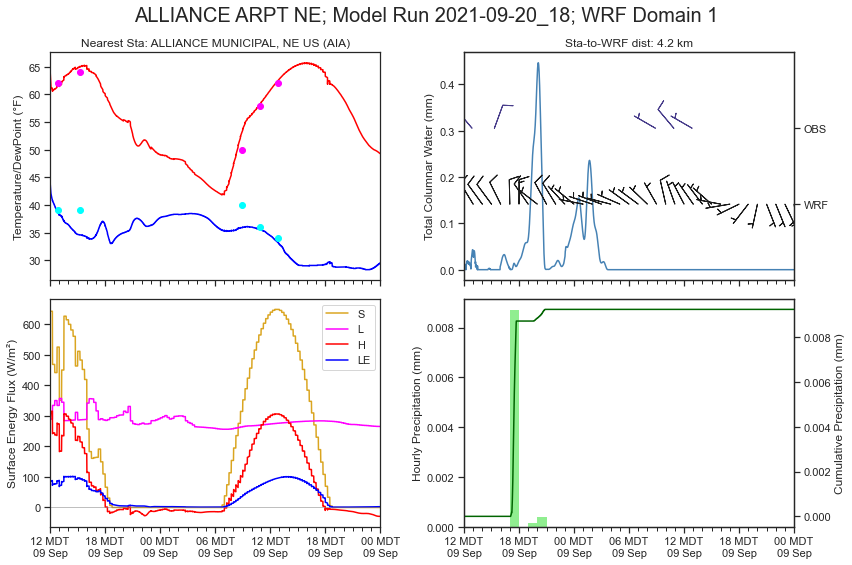

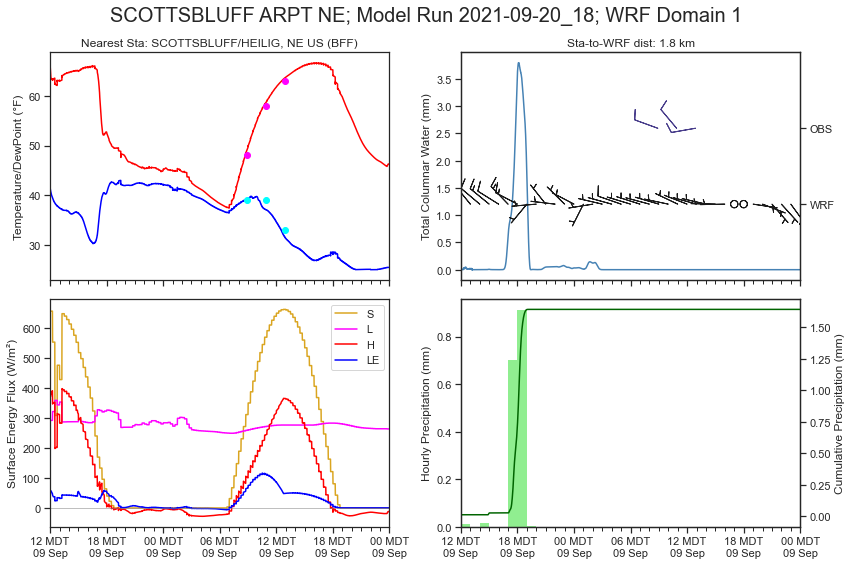

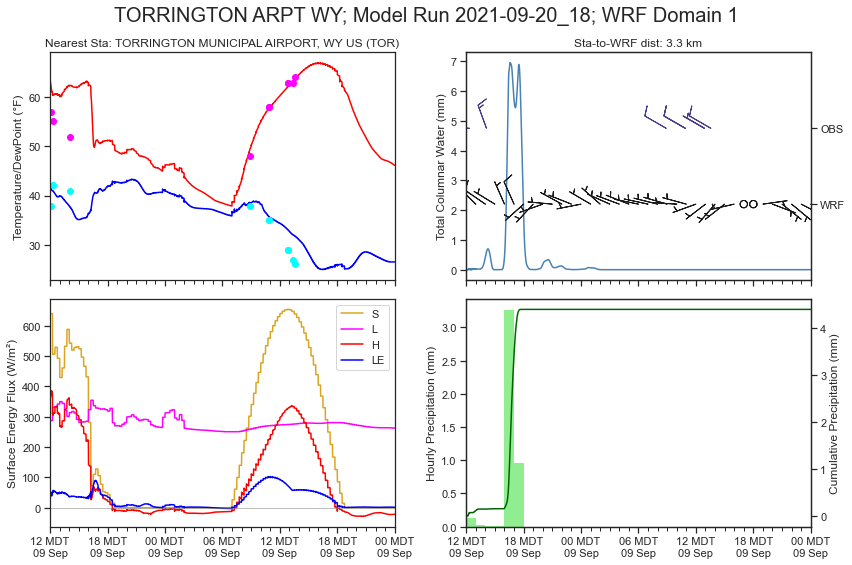

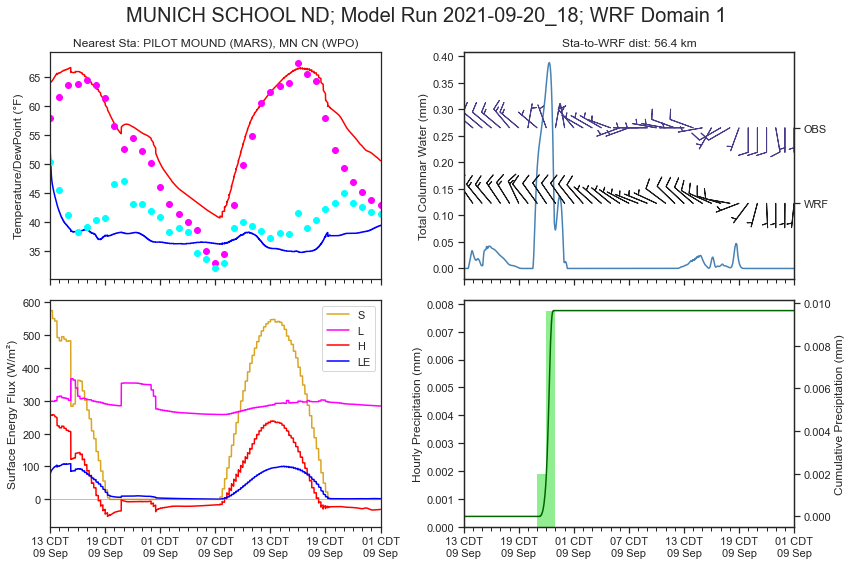

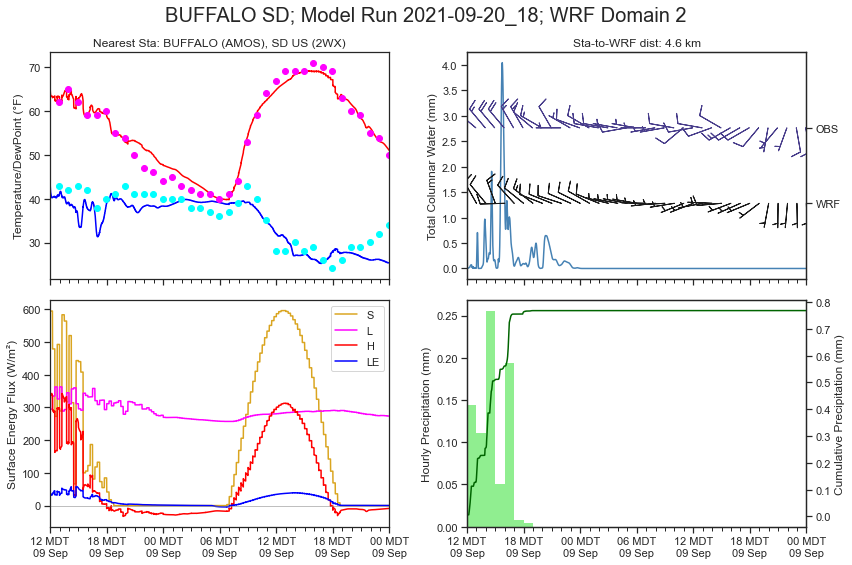

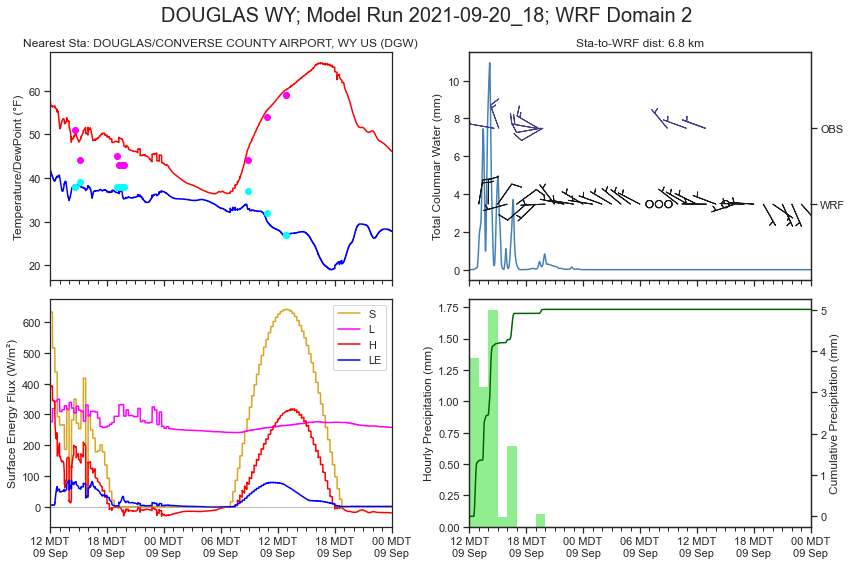

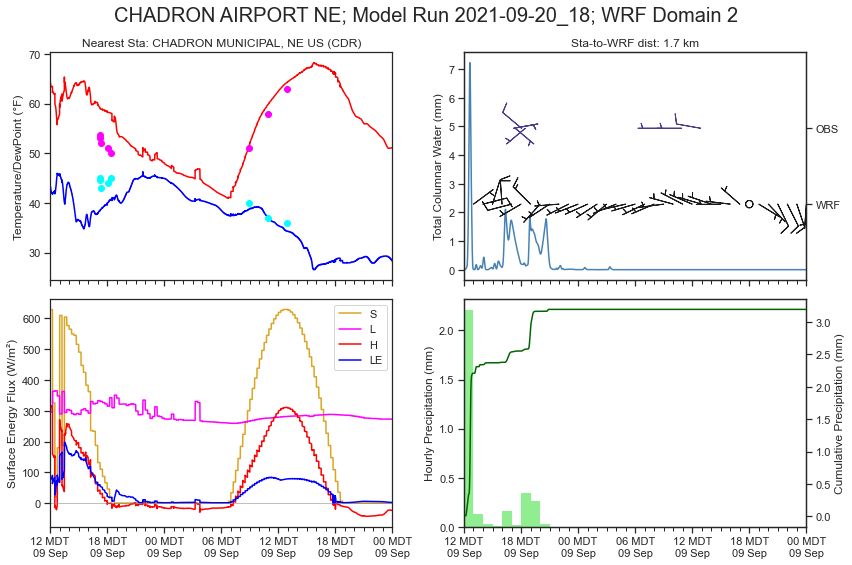

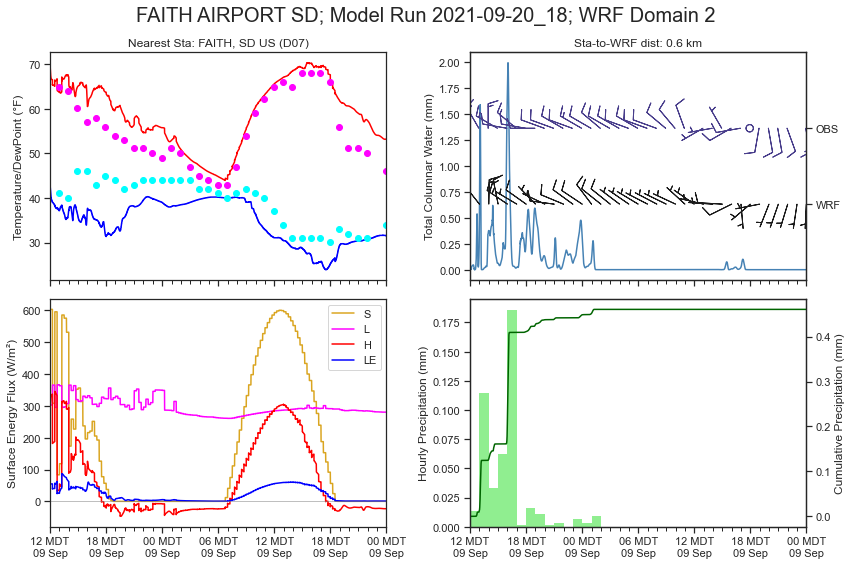

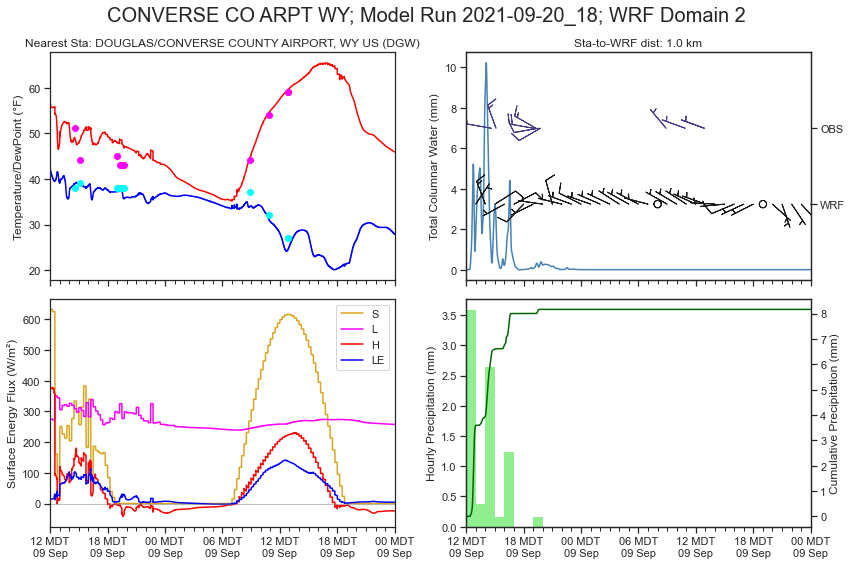

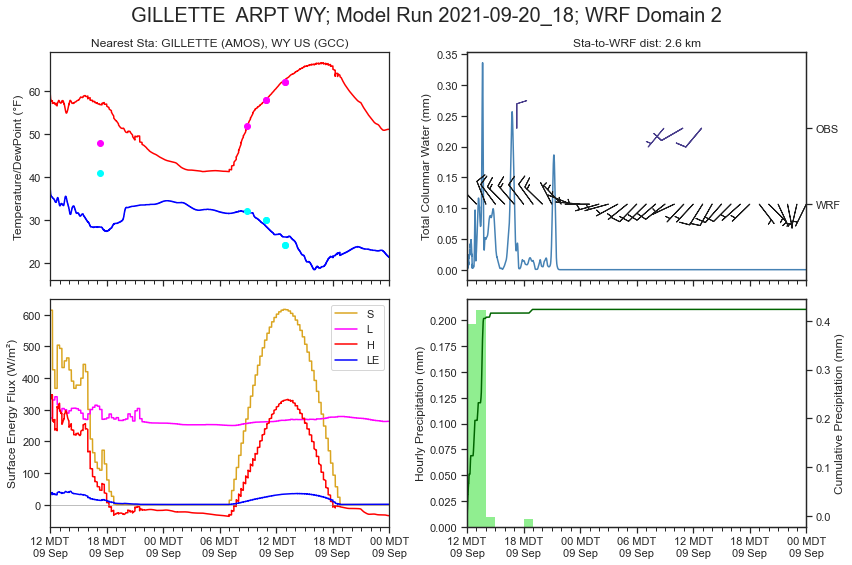

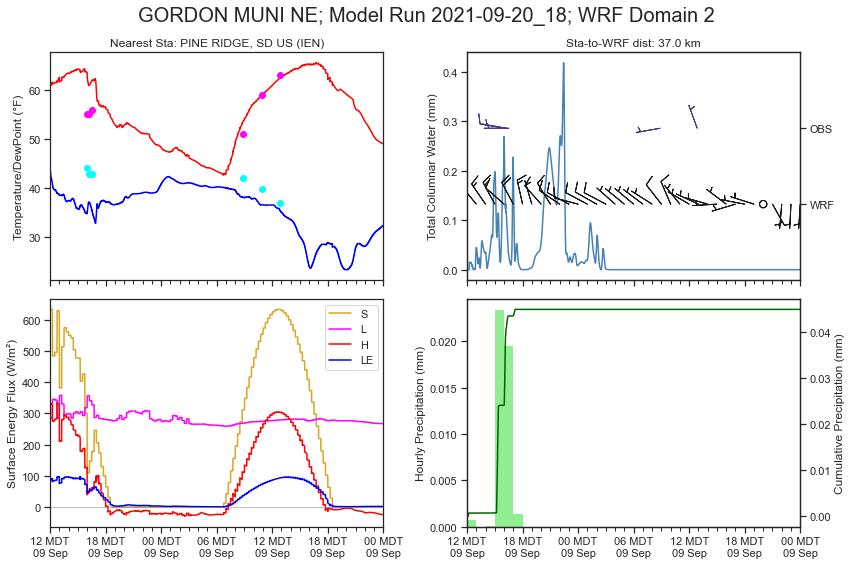

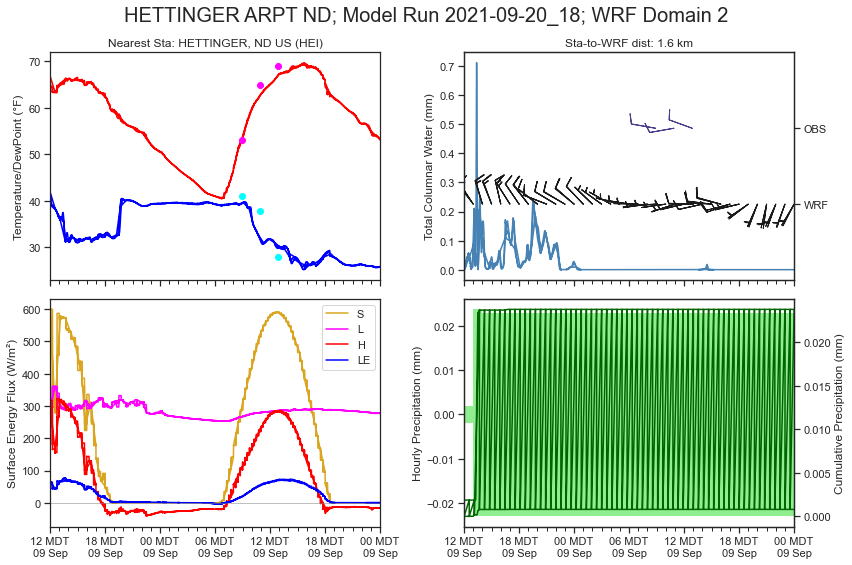

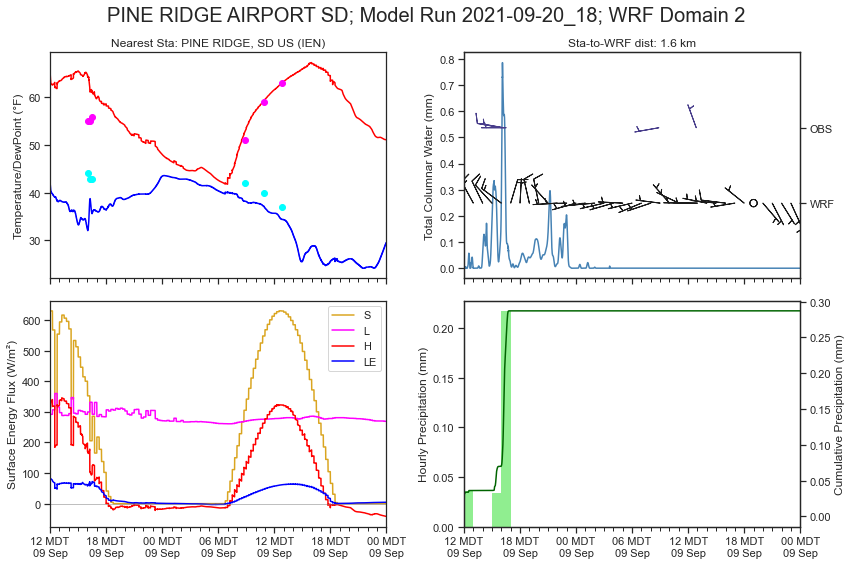

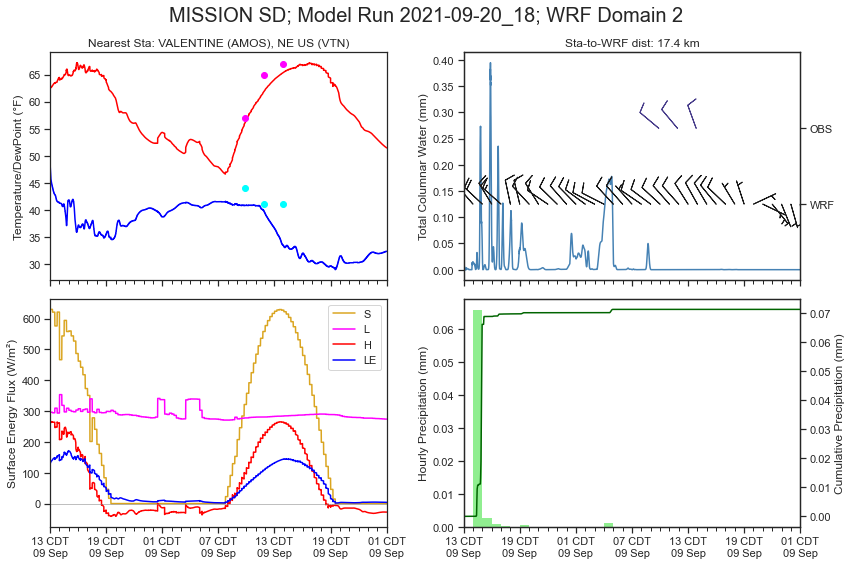

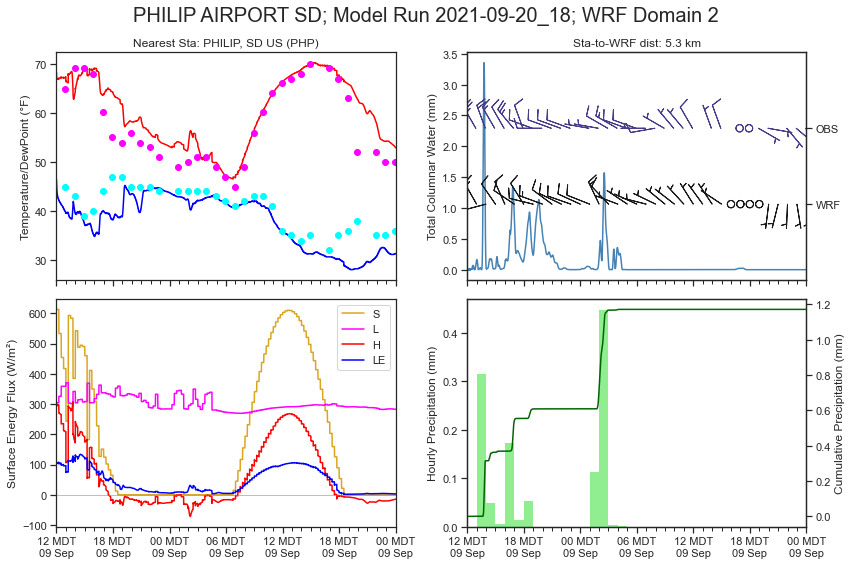

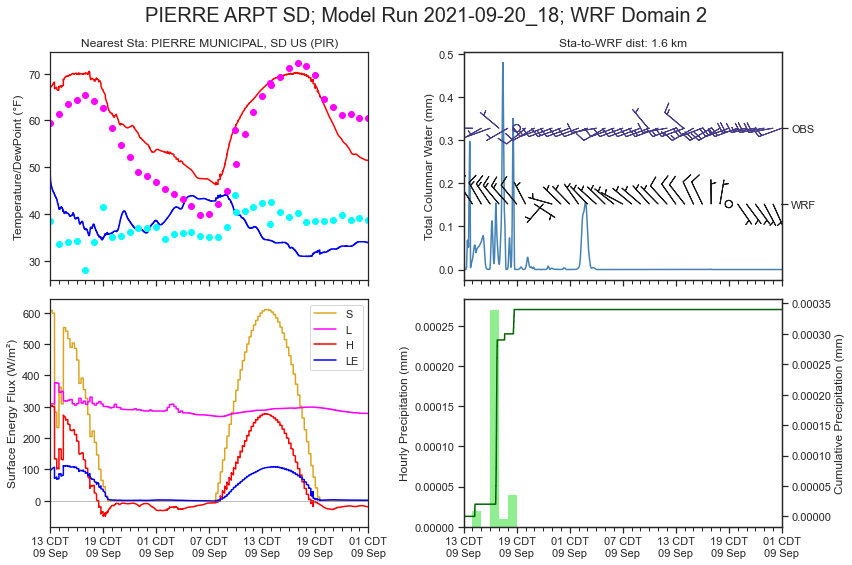

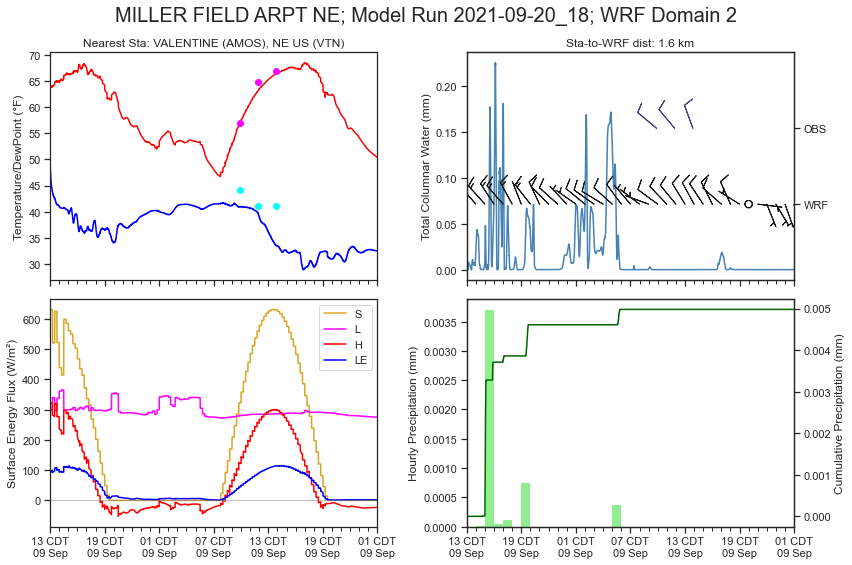

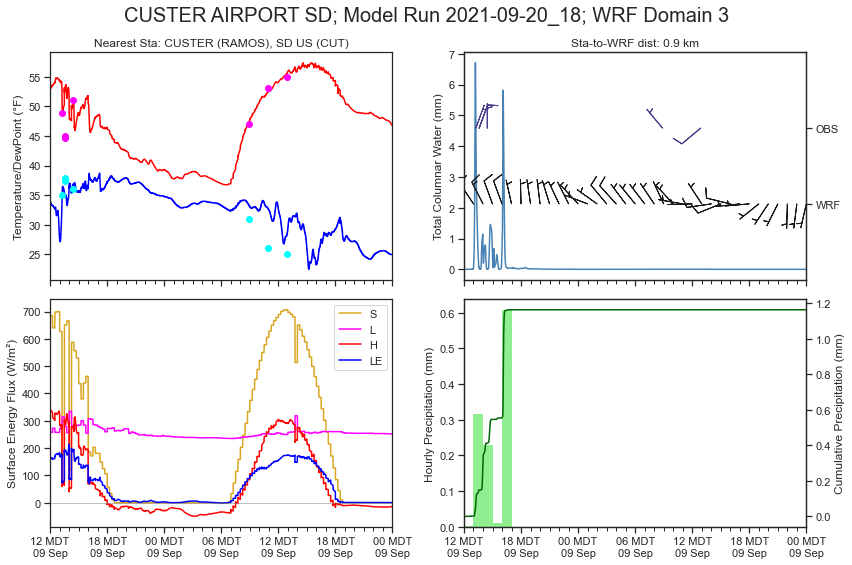

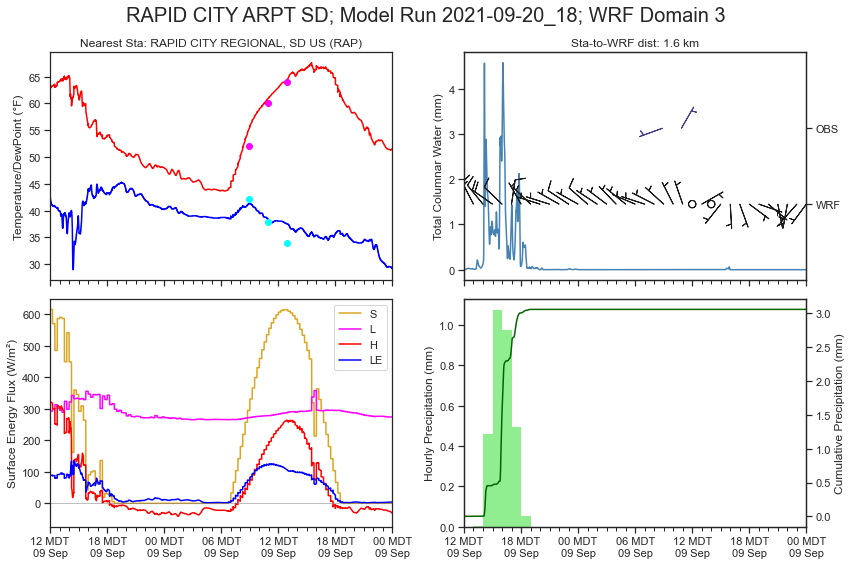

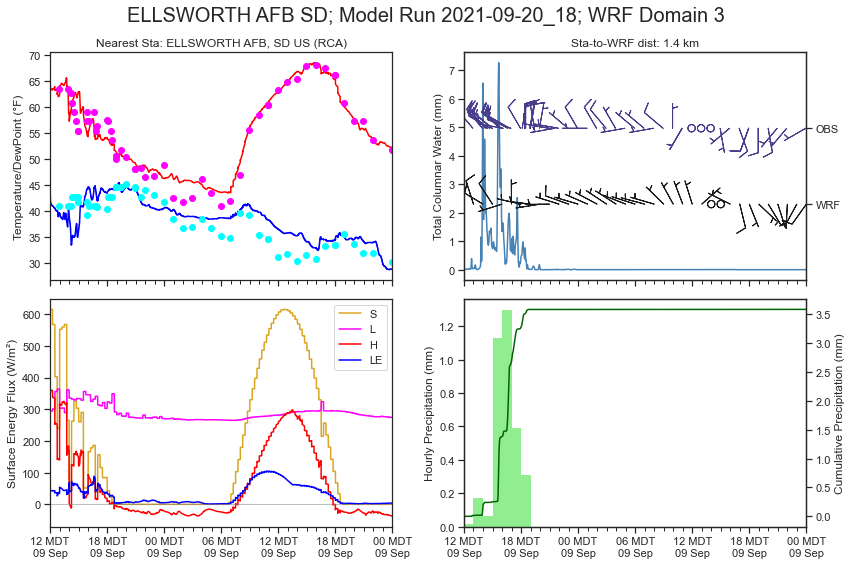

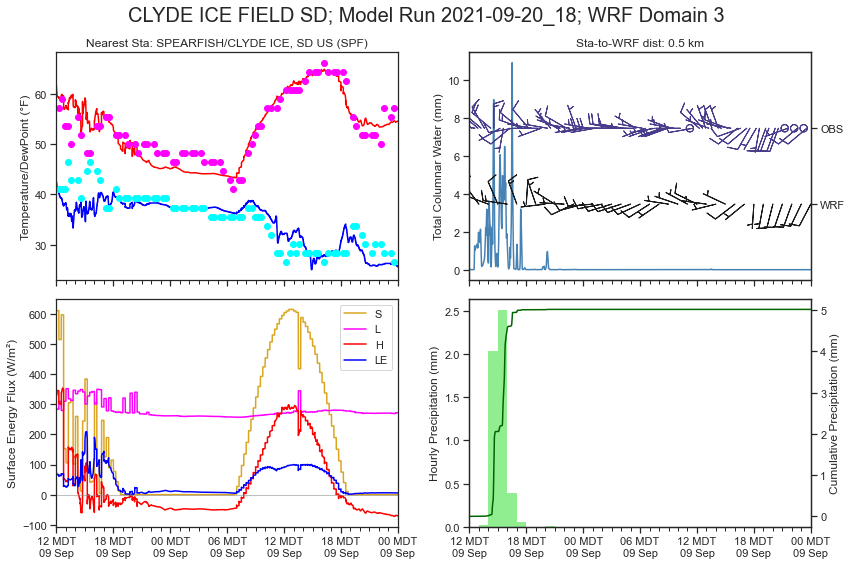

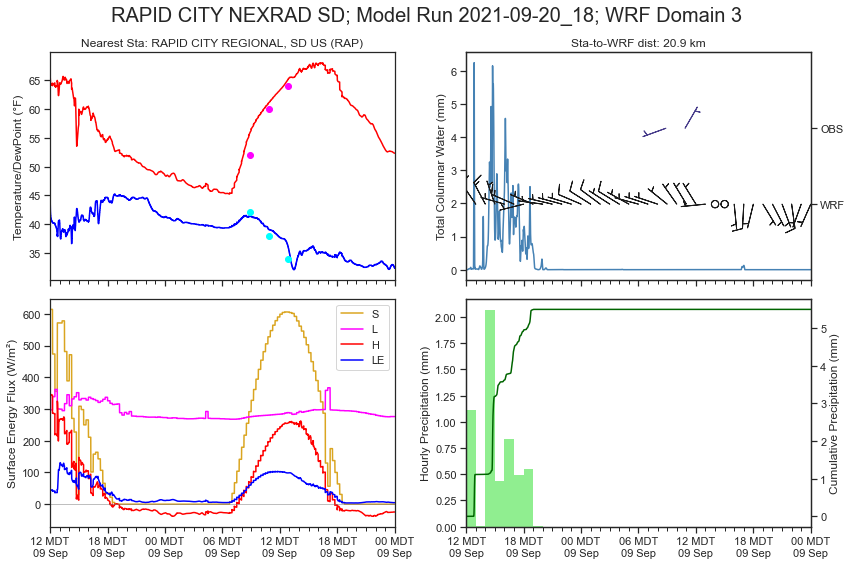

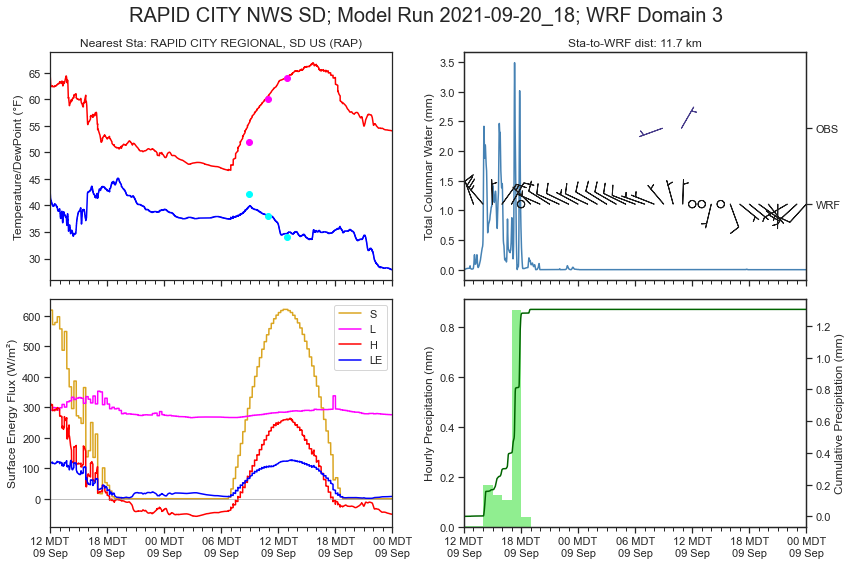

In [4]:

file_time = model_start_datetime.strftime('%Y-%m-%d_%H')


i=-32
for station in available_time_series_list.iterrows():

    ###################################################################
    #
    # Pull Station Data 
    #

    if (i>0):
        station = available_time_series_list.iloc[25]
    
        #display(station)
        #print(station[0])


        station_id     = station[0]
        grid_domain    = station[1]
        station_name   = station[2]
        station_lat    = station[3]
        station_lon    = station[4]
    else:
        #display(station)
        print(" ")


        station_id     = station[1][0]
        grid_domain    = station[1][1]
        station_name   = station[1][2]
        station_lat    = station[1][3]
        station_lon    = station[1][4]
        
    #    
    ###################################################################


    ###################################################################
    #
    # Pull WRF Time Series
    #
    
    netcdf_file_name = TS_DIR + "./wrfout_d"+str(grid_domain).zfill(2)+"_"+file_time+"_"+station_id+".nc"
    
    wrf_timeseries = xr.open_dataset(netcdf_file_name, 
                                 engine='netcdf4')
        
    #
    ###################################################################


    


    ###################################################################
    #
    # Pull NCSS Realtime Obs
    #

    #
    # Source Data Server
    #

    metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

    metar_cat = siphcat.TDSCatalog(metar_cat_url)

    dataset = list(siphcat.TDSCatalog(metar_cat_url).datasets.values())[0]

    ncss_url = dataset.access_urls["NetcdfSubset"]

    ncss = siphncss.NCSS(ncss_url)


    #
    # çonstruct query
    #

    query = ncss.query()
    query.lonlat_point(wrf_timeseries["wrf_grid_longitude"].values, 
                       wrf_timeseries["wrf_grid_latitude"].values)

    query.time_range(model_start_datetime, siphon_end_datetime)

    query.variables('air_pressure_at_sea_level',
                    'air_temperature',
                    'cloud_area_fraction',
                    'dew_point_temperature',
                    'hectoPascal_ALTIM',
                    'high_cloud_area_fraction',
                    'high_cloud_base_altitude',
                    'low_cloud_area_fraction',
                    'low_cloud_base_altitude',
                    'middle_cloud_area_fraction',
                    'middle_cloud_base_altitude',
                    'numChildren',
                    'precipitation_amount_24',
                    'precipitation_amount_hourly',
                    'report',
                    'report_id',
                    'report_length',
                    'snowfall_amount',
                    'snowfall_amount_last_hour',
                    'visibility_in_air',
                    'visibility_in_air_direction',
                    'visibility_in_air_surface',
                    'visibility_in_air_vertical',
                    'weather',
                    'wind_from_direction',
                    'wind_from_direction_max',
                    'wind_from_direction_min',
                    'wind_gust',
                    'wind_peak_from_direction',
                    'wind_peak_speed',
                    'wind_peak_time',
                    'wind_speed')
    query.accept('netcdf')

    #
    # Pull Querry
    #

    

    ncss_xarray_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(ncss.get_data(query)))
    ncss_xarray_dataset = ncss_xarray_dataset.sortby(["time"])
    
    metar_station_name = ncss_xarray_dataset["station_description"].values
    metar_station_ata  = ncss_xarray_dataset["station_id"].values
    
    metar_latitude  = ncss_xarray_dataset["latitude"].values
    metar_longitude = ncss_xarray_dataset["longitude"].values
    
    metar_to_sta_distance  = hs.haversine((metar_latitude,
                                           metar_longitude),
                                          (station_lat,
                                           station_lon))
    
    metar_to_wrf_distance = hs.haversine((metar_latitude,
                                          metar_longitude),
                                         (wrf_timeseries["wrf_grid_latitude"].values,
                                          wrf_timeseries["wrf_grid_longitude"].values))
    

    sta_to_wrf_distance   = hs.haversine((station_lat,
                                          station_lon),
                                         (wrf_timeseries["wrf_grid_latitude"].values,
                                          wrf_timeseries["wrf_grid_longitude"].values))


    #print("sta2metar = ", metar_to_sta_distance)
    #print("wrf2metar = ", metar_to_wrf_distance)

    #print("  sta2sta = ", sta_to_wrf_distance)

   
    
    
    #
    ###################################################################    
    

    ###################################################################
    ###################################################################
    #
    # Create Meteogram
    #



    ###################################################################
    #
    # Time Axes
    #
    
    tf     = tzf.TimezoneFinder()
    tz     = tf.certain_timezone_at(lng=station_lon, 
                                    lat=station_lat)
    
    tzabbr = pytz.timezone(tz).localize(model_start_datetime)

    wrf_times  = pd.to_datetime(wrf_timeseries["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)
    ncss_times = pd.to_datetime(ncss_xarray_dataset["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)


    wrf_time_seconds =  wrf_times.minute*60+wrf_times.second 
    on_the_hour      = np.where(wrf_time_seconds ==0)
    wrf_time_hrly    = wrf_times[on_the_hour]
    wrf_time_hrly_bar = wrf_times[on_the_hour]-datetime.timedelta(minutes=30)

    #
    ###################################################################


    ###################################################################
    #
    # Precip Prep
    #

    wrf_cum_prec      = wrf_timeseries["stratiform_precipitation_amount"].values + wrf_timeseries["convective_precipitation_amount"].values
    wrf_cum_hrly_prec = wrf_cum_prec[on_the_hour]
    wrf_hrly_prec     = wrf_cum_hrly_prec.copy()

    wrf_hrly_prec[1:] = wrf_cum_hrly_prec[1:] - wrf_cum_hrly_prec[0:-1]

    #
    ###################################################################

    ###################################################################
    #
    # Wind Barb Prep
    #

    u_wrf = (wrf_timeseries["eastward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]
    v_wrf = (wrf_timeseries["northward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]

    obs_winddir   = ncss_xarray_dataset["wind_from_direction"] * units.deg
    obs_windspeed = ( ncss_xarray_dataset["wind_speed"] * units("m")/units("s")).pint.to("knots") 

    u_obs, v_obs =  mpcalc.wind_components(obs_windspeed, obs_winddir) 

    #
    ###################################################################

    ###################################################################
    #
    # Plot Meteogram
    #

    fig, ax = plt.subplots(figsize = (12, 8),
                           nrows   =  2, 
                           ncols   =  2,
                           sharex  =  True)

    date_form = mdates.DateFormatter("%H %Z\n%m %b", tz=pytz.timezone(tz))
    xmajor = mdates.HourLocator(interval = 6)
    xminor = mdates.HourLocator(interval = 1)

    #
    # Temperature and Humidity
    #
    
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["air_temperature_2m"]*units("K")).pint.to("degF"),
              color = "red")
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["dew_point_temperature_2m"]*units("K")).pint.to("degF"),
              color = "blue")

    ax[0,0].plot(ncss_times,
             (ncss_xarray_dataset["air_temperature"]*units("degC")).pint.to("degF"),
             marker = "o",
             color="magenta",
            linestyle = "None")
    ax[0,0].plot(ncss_times,
             (ncss_xarray_dataset["dew_point_temperature"]*units("degC")).pint.to("degF"),
             marker = "o",
             color="cyan",
            linestyle = "None")
    ax[0,0].set_ylabel("Temperature/DewPoint (°F)")
    ax[0,0].set_title("Nearest Sta: "+metar_station_name[0].astype('U') +" ("+metar_station_ata[0].astype('U') +")")
    ax[0,1].set_title("Sta-to-WRF dist: "+str(round(metar_to_wrf_distance,1)) +" km")


    #
    # Total Atmos Column Water + Wind Speed
    #
    
    ax[0,1].plot(wrf_times,
            wrf_timeseries["atmosphere_mass_content_of_water"],
              color = "steelblue")
    ax[0,1].set_ylabel("Total Columnar Water (mm)")
 

    ax01 = ax[0,1].twinx()
    
    ax01.set_ylim(0,1)
    ax01.set_yticks([1/3.,2/3.])
    ax01.set_yticklabels(["WRF","OBS"])

    ax01.barbs( wrf_time_hrly, 1/3.,  u_wrf, v_wrf )
    ax01.barbs( ncss_times,    2/3.,  u_obs, v_obs, color="darkslateblue")

   
    
    #
    # Surface Energy Budget
    #

    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_shortwave_flux"],
                 color = "goldenrod")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_longwave_flux"],
                 color = "magenta")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_sensible_heat_flux"],
                 color = "red")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_latent_heat_flux"],
                 color = "blue")
    ax[1,0].legend(["S","L","H","LE"])
    ax[1,0].set_ylabel("Surface Energy Flux (W/m²)")

    ax[1,0].axhline(y=0,color="grey", linewidth=0.5)

 

    #
    # Precipitation
    #

    ax[1,1].bar(wrf_time_hrly_bar,
                wrf_hrly_prec,
                linewidth=0,
                width=1/24, 
                color="lightgreen",
                edgecolor=None)
    ax11 = ax[1,1].twinx()
    ax11.plot(wrf_times,
              wrf_cum_prec, 
              color="darkgreen")
    ax11.set_ylabel("Cumulative Precipitation (mm)")
    ax[1,1].set_ylabel("Hourly Precipitation (mm)")

    fig.suptitle(station_name+"; Model Run "+file_time+"; WRF Domain "+str(grid_domain),
                 fontsize=20)


    ax[1,0].set_xlim(model_start_datetime, siphon_end_datetime)
    ax[1,0].xaxis.set_major_formatter(date_form)
    ax[1,0].xaxis.set_major_locator(xmajor)
    ax[1,0].xaxis.set_minor_locator(xminor)
    ax[1,0].xaxis_date()

    ax[1,1].set_xlim(model_start_datetime, siphon_end_datetime)
    ax[1,1].xaxis.set_major_formatter(date_form)
    ax[1,1].xaxis.set_major_locator(xmajor)
    ax[1,1].xaxis.set_minor_locator(xminor)
    ax[1,1].xaxis_date()



    plt.tight_layout()
    plt.subplots_adjust(top=0.90)


    plt.show()
    
    fig.savefig("./wrfout_dxx_"+file_time+"_"+station_id+".png")


    #
    ###################################################################

    #
    ###################################################################
    ###################################################################
    
    print(" ")

